In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.nn.parameter import Parameter
import torchvision
from torchvision import transforms

from SpykeTorch import snn
from SpykeTorch import functional as sf
from SpykeTorch import visualization as vis
from SpykeTorch import utils
#from SpykeTorch import makeInput
#import cifar10

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time

In [2]:
rf_size = 28 # Receptive field size that will be provided as input to the column
num_neurons = rf_size*rf_size # Number of excitatory neurons in the column
startposition = 0 # Start position of the receptive field w.r.t. top left corner of image
threshold = 75 # Firing threshold for every excitatory neuron
timesteps = 8 # Resolution for timesteps and weights

In [3]:
class PreProcTransform:
    def __init__(self, filter, timesteps = timesteps):
        self.to_tensor = transforms.ToTensor() # Convert to tensor
        self.filter = filter # Apply OnOff filtering
        self.temporal_transform = utils.Intensity2Latency(timesteps) # Convert pixel values to time
                                                    # Higher value corresponds to earlier spiketime
        self.crop = utils.Crop(startposition, rf_size) # Crop the image to form the receptive field
        
    def __call__(self, image):
        image = self.to_tensor(image) * 255
        image.unsqueeze_(0) # Adds a temporal dimension at the beginning
        image = self.filter(image)
        temporal_image = self.temporal_transform(image)
        temporal_image = temporal_image.sign() # This will create spikes
        return self.crop(temporal_image)
    
kernels = [utils.OnKernel(3), utils.OffKernel(3)]
inchannels = len(kernels)

filter = utils.Filter(kernels, padding = 2, thresholds = 50)
preproc = PreProcTransform(filter)

In [4]:
data_root = "data"
MNIST_train = utils.CacheDataset(torchvision.datasets.MNIST(root=data_root, train=True, download=True, transform = preproc))
MNIST_test = utils.CacheDataset(torchvision.datasets.MNIST(root=data_root, train=False, download=True, transform = preproc))
MNIST_trainLoader = DataLoader(MNIST_train, batch_size=1000, shuffle=True)
MNIST_testLoader = DataLoader(MNIST_test, batch_size=1000, shuffle=True)

In [5]:
class Column(nn.Module):
    def __init__(self):
        super(Column, self).__init__()
        # Local Convolution layer which creates columns with unique weights (NOT shared weights). The
        # number of columns is based on input_size, kernel_size and stride. Here since we are simulating
        # only one column, the input_size and kernel_size are kept same.
        self.ec = snn.HopfieldNetwork()
        # STDP module which implements the given STDP rule for the above layer (a single column in this case)
        self.stdp = snn.ModSTDP(self.ec, 10/128, 10/128, 1/128, 96/128, 4/128, maxweight = timesteps)
        
    def forward(self, rec_field):
        ### Start of Excitatory Column ###
        out = self.ec(rec_field)
        #spike, pot = sf.fire(out, threshold, True)
        ### End of Excitatory Column ###
        ### Start of Lateral Inhibition ###
        #out = sf.pointwise_inhibition(pot).sign()
        ### End of Lateral Inhibition ###
        return out

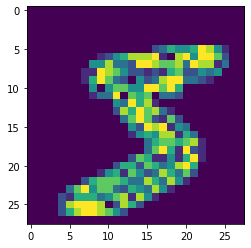

In [6]:
MyColumn=Column()
train_pattern=[torch.sum(torch.sum(MNIST_train[0][0],dim=0),dim=0)]#,torch.sum(torch.sum(MNIST_train[2][0],dim=0),dim=0)]#[torch.tensor([7,0,0,0,0,7,0,0,0,0,7,0,0,0,0,7]).type(torch.FloatTensor).reshape(4,4)]
MyColumn.ec.train_weights(train_pattern)#[torch.tensor([0,1,2,3,4,5,6,7]*2).reshape(4,4)])#[torch.sum(torch.sum(MNIST_train[0][0],dim=0),dim=0)])
plt.imshow(train_pattern[0])#torch.tensor([0,1,2,3,4,5,6,7]*2).reshape(4,4))#torch.sum(torch.sum(MNIST_train[0][0],dim=0),dim=0))
#MyColumn.ec.train_weights([torch.sum(torch.sum(MNIST_train[0][0],dim=0),dim=0)])
#plt.imshow(torch.sum(torch.sum(MNIST_train[0][0],dim=0),dim=0))

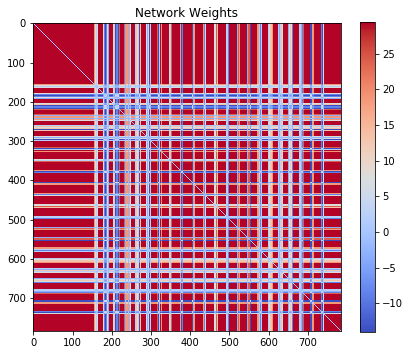

In [7]:
plt.figure(figsize=(6, 5))
w_mat = plt.imshow(MyColumn.ec.W, cmap=cm.coolwarm)
plt.colorbar(w_mat)
plt.title("Network Weights")
plt.tight_layout()
plt.savefig("weights.png")
plt.show()

In [33]:
pattern=torch.sum(torch.sum(MNIST_train[1][0],dim=0),dim=0).reshape(784)#torch.tensor([0]*784).type(torch.FloatTensor)#torch.tensor([2,6,3,1,7,4,5,2,7,7,7,7,3,7,5,5]).type(torch.FloatTensor)#(torch.tensor([0,1,2,3,4,5,6,7]*2).type(torch.FloatTensor))#torch.sum(torch.sum(MNIST_train[1][0],dim=0),dim=0).reshape(784)-4)/4
out=MyColumn.ec.forward([(pattern-4).clone()],20)

tensor([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])
tensor(-51741.1172)
tensor(-8.9863)
tensor([ 4.9863,  5.9863,  6.9863,  7.9863,  8.9863,  9.9863, 10.9863, 11.9863,
        12.9863])
tensor(0)
tensor(-4.)
tensor(-51741.1172)
tensor(-8.9863)
tensor([ 4.9863,  5.9863,  6.9863,  7.9863,  8.9863,  9.9863, 10.9863, 11.9863,
        12.9863])
tensor(0)
tensor(-4.)
tensor(-23149.5273)
tensor(-4.0206)
tensor([0.0206, 1.0206, 2.0206, 3.0206, 4.0206, 5.0206, 6.0206, 7.0206, 8.0206])
tensor(0)
tensor(-4.)
tensor(-51741.1172)
tensor(-8.9863)
tensor([ 4.9863,  5.9863,  6.9863,  7.9863,  8.9863,  9.9863, 10.9863, 11.9863,
        12.9863])
tensor(0)
tensor(-4.)
tensor(-51741.1172)
tensor(-8.9863)
tensor([ 4.9863,  5.9863,  6.9863,  7.9863,  8.9863,  9.9863, 10.9863, 11.9863,
        12.9863])
tensor(0)
tensor(-4.)
tensor(5514.0669)
tensor(0.9577)
tensor([4.9577, 3.9577, 2.9577, 1.9577, 0.9577, 0.0423, 1.0423, 2.0423, 3.0423])
tensor(5)
tensor(1.)
tensor(-51962.6523)
tensor(-9.0247)
tensor([ 5.0

tensor([ 5.2660,  6.2660,  7.2660,  8.2660,  9.2660, 10.2660, 11.2660, 12.2660,
        13.2660])
tensor(0)
tensor(-4.)
tensor(-53351.6953)
tensor(-9.2660)
tensor([ 5.2660,  6.2660,  7.2660,  8.2660,  9.2660, 10.2660, 11.2660, 12.2660,
        13.2660])
tensor(0)
tensor(-4.)
tensor(-43551.7734)
tensor(-7.5640)
tensor([ 3.5640,  4.5640,  5.5640,  6.5640,  7.5640,  8.5640,  9.5640, 10.5640,
        11.5640])
tensor(0)
tensor(-4.)
tensor(-53375.6875)
tensor(-9.2702)
tensor([ 5.2702,  6.2702,  7.2702,  8.2702,  9.2702, 10.2702, 11.2702, 12.2702,
        13.2702])
tensor(0)
tensor(-4.)
tensor(-14040.1162)
tensor(-2.4385)
tensor([1.5615, 0.5615, 0.4385, 1.4385, 2.4385, 3.4385, 4.4385, 5.4385, 6.4385])
tensor(2)
tensor(-2.)
tensor(-53391.1289)
tensor(-9.2728)
tensor([ 5.2728,  6.2728,  7.2728,  8.2728,  9.2728, 10.2728, 11.2728, 12.2728,
        13.2728])
tensor(0)
tensor(-4.)
tensor(-53391.1289)
tensor(-9.2728)
tensor([ 5.2728,  6.2728,  7.2728,  8.2728,  9.2728, 10.2728, 11.2728, 12.2728,
 

tensor(-4.)
tensor(-54689.9375)
tensor(-9.4984)
tensor([ 5.4984,  6.4984,  7.4984,  8.4984,  9.4984, 10.4984, 11.4984, 12.4984,
        13.4984])
tensor(0)
tensor(-4.)
tensor(-54689.9375)
tensor(-9.4984)
tensor([ 5.4984,  6.4984,  7.4984,  8.4984,  9.4984, 10.4984, 11.4984, 12.4984,
        13.4984])
tensor(0)
tensor(-4.)
tensor(-54689.9375)
tensor(-9.4984)
tensor([ 5.4984,  6.4984,  7.4984,  8.4984,  9.4984, 10.4984, 11.4984, 12.4984,
        13.4984])
tensor(0)
tensor(-4.)
tensor(-54689.9375)
tensor(-9.4984)
tensor([ 5.4984,  6.4984,  7.4984,  8.4984,  9.4984, 10.4984, 11.4984, 12.4984,
        13.4984])
tensor(0)
tensor(-4.)
tensor(-54689.9375)
tensor(-9.4984)
tensor([ 5.4984,  6.4984,  7.4984,  8.4984,  9.4984, 10.4984, 11.4984, 12.4984,
        13.4984])
tensor(0)
tensor(-4.)
tensor(-14376.9551)
tensor(-2.4970)
tensor([1.5030, 0.5030, 0.4970, 1.4970, 2.4970, 3.4970, 4.4970, 5.4970, 6.4970])
tensor(2)
tensor(-2.)
tensor(5825.2285)
tensor(1.0117)
tensor([5.0117, 4.0117, 3.0117, 2.01

tensor(16214.0547)
tensor(2.8160)
tensor([6.8160, 5.8160, 4.8160, 3.8160, 2.8160, 1.8160, 0.8160, 0.1840, 1.1840])
tensor(7)
tensor(3.)
tensor(-14648.6348)
tensor(-2.5441)
tensor([1.4559, 0.4559, 0.5441, 1.5441, 2.5441, 3.5441, 4.5441, 5.5441, 6.5441])
tensor(1)
tensor(-3.)
tensor(-55893.8047)
tensor(-9.7075)
tensor([ 5.7075,  6.7075,  7.7075,  8.7075,  9.7075, 10.7075, 11.7075, 12.7075,
        13.7075])
tensor(0)
tensor(-4.)
tensor(-55893.8086)
tensor(-9.7075)
tensor([ 5.7075,  6.7075,  7.7075,  8.7075,  9.7075, 10.7075, 11.7075, 12.7075,
        13.7075])
tensor(0)
tensor(-4.)
tensor(-55893.8047)
tensor(-9.7075)
tensor([ 5.7075,  6.7075,  7.7075,  8.7075,  9.7075, 10.7075, 11.7075, 12.7075,
        13.7075])
tensor(0)
tensor(-4.)
tensor(-55952.6367)
tensor(-9.7177)
tensor([ 5.7177,  6.7177,  7.7177,  8.7177,  9.7177, 10.7177, 11.7177, 12.7177,
        13.7177])
tensor(0)
tensor(-4.)
tensor(-14708.3701)
tensor(-2.5545)
tensor([1.4455, 0.4455, 0.5545, 1.5545, 2.5545, 3.5545, 4.5545, 5

tensor(-0.7866)
tensor([3.2134, 2.2134, 1.2134, 0.2134, 0.7866, 1.7866, 2.7866, 3.7866, 4.7866])
tensor(3)
tensor(-1.)
tensor(-58068.4805)
tensor(-10.0852)
tensor([ 6.0852,  7.0852,  8.0852,  9.0852, 10.0852, 11.0852, 12.0852, 13.0852,
        14.0852])
tensor(0)
tensor(-4.)
tensor(16916.4238)
tensor(2.9380)
tensor([6.9380, 5.9380, 4.9380, 3.9380, 2.9380, 1.9380, 0.9380, 0.0620, 1.0620])
tensor(7)
tensor(3.)
tensor(27685.3203)
tensor(4.8083)
tensor([8.8083, 7.8083, 6.8083, 5.8083, 4.8083, 3.8083, 2.8083, 1.8083, 0.8083])
tensor(8)
tensor(4.)
tensor(-58214.4727)
tensor(-10.1105)
tensor([ 6.1105,  7.1105,  8.1105,  9.1105, 10.1105, 11.1105, 12.1105, 13.1105,
        14.1105])
tensor(0)
tensor(-4.)
tensor(-58214.4727)
tensor(-10.1105)
tensor([ 6.1105,  7.1105,  8.1105,  9.1105, 10.1105, 11.1105, 12.1105, 13.1105,
        14.1105])
tensor(0)
tensor(-4.)
tensor(-58361.5430)
tensor(-10.1361)
tensor([ 6.1361,  7.1361,  8.1361,  9.1361, 10.1361, 11.1361, 12.1361, 13.1361,
        14.1361])
ten

tensor(-59955.7109)
tensor(-10.4130)
tensor([ 6.4130,  7.4130,  8.4130,  9.4130, 10.4130, 11.4130, 12.4130, 13.4130,
        14.4130])
tensor(0)
tensor(-4.)
tensor(-59955.7109)
tensor(-10.4130)
tensor([ 6.4130,  7.4130,  8.4130,  9.4130, 10.4130, 11.4130, 12.4130, 13.4130,
        14.4130])
tensor(0)
tensor(-4.)
tensor(-59955.7109)
tensor(-10.4130)
tensor([ 6.4130,  7.4130,  8.4130,  9.4130, 10.4130, 11.4130, 12.4130, 13.4130,
        14.4130])
tensor(0)
tensor(-4.)
tensor(-59955.7109)
tensor(-10.4130)
tensor([ 6.4130,  7.4130,  8.4130,  9.4130, 10.4130, 11.4130, 12.4130, 13.4130,
        14.4130])
tensor(0)
tensor(-4.)
tensor(-59955.7109)
tensor(-10.4130)
tensor([ 6.4130,  7.4130,  8.4130,  9.4130, 10.4130, 11.4130, 12.4130, 13.4130,
        14.4130])
tensor(0)
tensor(-4.)
tensor(-60043.9531)
tensor(-10.4283)
tensor([ 6.4283,  7.4283,  8.4283,  9.4283, 10.4283, 11.4283, 12.4283, 13.4283,
        14.4283])
tensor(0)
tensor(-4.)
tensor(-60191.0234)
tensor(-10.4538)
tensor([ 6.4538,  7.4

tensor(0)
tensor(-4.)
tensor(-39207.9531)
tensor(-6.8095)
tensor([ 2.8095,  3.8095,  4.8095,  5.8095,  6.8095,  7.8095,  8.8095,  9.8095,
        10.8095])
tensor(0)
tensor(-4.)
tensor(-62099.3672)
tensor(-10.7853)
tensor([ 6.7853,  7.7853,  8.7853,  9.7853, 10.7853, 11.7853, 12.7853, 13.7853,
        14.7853])
tensor(0)
tensor(-4.)
tensor(-62099.3633)
tensor(-10.7853)
tensor([ 6.7853,  7.7853,  8.7853,  9.7853, 10.7853, 11.7853, 12.7853, 13.7853,
        14.7853])
tensor(0)
tensor(-4.)
tensor(-62099.3633)
tensor(-10.7853)
tensor([ 6.7853,  7.7853,  8.7853,  9.7853, 10.7853, 11.7853, 12.7853, 13.7853,
        14.7853])
tensor(0)
tensor(-4.)
tensor(-62099.3672)
tensor(-10.7853)
tensor([ 6.7853,  7.7853,  8.7853,  9.7853, 10.7853, 11.7853, 12.7853, 13.7853,
        14.7853])
tensor(0)
tensor(-4.)
tensor(-62099.3672)
tensor(-10.7853)
tensor([ 6.7853,  7.7853,  8.7853,  9.7853, 10.7853, 11.7853, 12.7853, 13.7853,
        14.7853])
tensor(0)
tensor(-4.)
tensor(-62099.3672)
tensor(-10.7853)


tensor(-4.)
tensor(-63535.6172)
tensor(-11.0347)
tensor([ 7.0347,  8.0347,  9.0347, 10.0347, 11.0347, 12.0347, 13.0347, 14.0347,
        15.0347])
tensor(0)
tensor(-4.)
tensor(-16704.7148)
tensor(-2.9012)
tensor([1.0988, 0.0988, 0.9012, 1.9012, 2.9012, 3.9012, 4.9012, 5.9012, 6.9012])
tensor(1)
tensor(-3.)
tensor(-63551.0547)
tensor(-11.0374)
tensor([ 7.0374,  8.0374,  9.0374, 10.0374, 11.0374, 12.0374, 13.0374, 14.0374,
        15.0374])
tensor(0)
tensor(-4.)
tensor(-63551.0547)
tensor(-11.0374)
tensor([ 7.0374,  8.0374,  9.0374, 10.0374, 11.0374, 12.0374, 13.0374, 14.0374,
        15.0374])
tensor(0)
tensor(-4.)
tensor(-63551.0547)
tensor(-11.0374)
tensor([ 7.0374,  8.0374,  9.0374, 10.0374, 11.0374, 12.0374, 13.0374, 14.0374,
        15.0374])
tensor(0)
tensor(-4.)
tensor(-63698.1250)
tensor(-11.0629)
tensor([ 7.0629,  8.0629,  9.0629, 10.0629, 11.0629, 12.0629, 13.0629, 14.0629,
        15.0629])
tensor(0)
tensor(-4.)
tensor(-63698.1250)
tensor(-11.0629)
tensor([ 7.0629,  8.0629,  

tensor(-4.)
tensor(-65272.3984)
tensor(-11.3364)
tensor([ 7.3364,  8.3364,  9.3364, 10.3364, 11.3364, 12.3364, 13.3364, 14.3364,
        15.3364])
tensor(0)
tensor(-4.)
tensor(-5105.5376)
tensor(-0.8867)
tensor([3.1133, 2.1133, 1.1133, 0.1133, 0.8867, 1.8867, 2.8867, 3.8867, 4.8867])
tensor(3)
tensor(-1.)
tensor(-65272.3984)
tensor(-11.3364)
tensor([ 7.3364,  8.3364,  9.3364, 10.3364, 11.3364, 12.3364, 13.3364, 14.3364,
        15.3364])
tensor(0)
tensor(-4.)
tensor(-65272.3984)
tensor(-11.3364)
tensor([ 7.3364,  8.3364,  9.3364, 10.3364, 11.3364, 12.3364, 13.3364, 14.3364,
        15.3364])
tensor(0)
tensor(-4.)
tensor(-65272.3984)
tensor(-11.3364)
tensor([ 7.3364,  8.3364,  9.3364, 10.3364, 11.3364, 12.3364, 13.3364, 14.3364,
        15.3364])
tensor(0)
tensor(-4.)
tensor(-65272.3984)
tensor(-11.3364)
tensor([ 7.3364,  8.3364,  9.3364, 10.3364, 11.3364, 12.3364, 13.3364, 14.3364,
        15.3364])
tensor(0)
tensor(-4.)
tensor(-65272.3984)
tensor(-11.3364)
tensor([ 7.3364,  8.3364,  9

tensor(-66282.8828)
tensor(-11.5119)
tensor([ 7.5119,  8.5119,  9.5119, 10.5119, 11.5119, 12.5119, 13.5119, 14.5119,
        15.5119])
tensor(0)
tensor(-4.)
tensor(-66341.7109)
tensor(-11.5221)
tensor([ 7.5221,  8.5221,  9.5221, 10.5221, 11.5221, 12.5221, 13.5221, 14.5221,
        15.5221])
tensor(0)
tensor(-4.)
tensor(-66341.7109)
tensor(-11.5221)
tensor([ 7.5221,  8.5221,  9.5221, 10.5221, 11.5221, 12.5221, 13.5221, 14.5221,
        15.5221])
tensor(0)
tensor(-4.)
tensor(-66518.1953)
tensor(-11.5527)
tensor([ 7.5527,  8.5527,  9.5527, 10.5527, 11.5527, 12.5527, 13.5527, 14.5527,
        15.5527])
tensor(0)
tensor(-4.)
tensor(-5202.9893)
tensor(-0.9036)
tensor([3.0964, 2.0964, 1.0964, 0.0964, 0.9036, 1.9036, 2.9036, 3.9036, 4.9036])
tensor(3)
tensor(-1.)
tensor(-66520.4922)
tensor(-11.5531)
tensor([ 7.5531,  8.5531,  9.5531, 10.5531, 11.5531, 12.5531, 13.5531, 14.5531,
        15.5531])
tensor(0)
tensor(-4.)
tensor(-5203.5273)
tensor(-0.9037)
tensor([3.0963, 2.0963, 1.0963, 0.0963, 0.

tensor([ 7.7190,  8.7190,  9.7190, 10.7190, 11.7190, 12.7190, 13.7190, 14.7190,
        15.7190])
tensor(0)
tensor(-4.)
tensor(-67475.7109)
tensor(-11.7190)
tensor([ 7.7190,  8.7190,  9.7190, 10.7190, 11.7190, 12.7190, 13.7190, 14.7190,
        15.7190])
tensor(0)
tensor(-4.)
tensor(-67475.7109)
tensor(-11.7190)
tensor([ 7.7190,  8.7190,  9.7190, 10.7190, 11.7190, 12.7190, 13.7190, 14.7190,
        15.7190])
tensor(0)
tensor(-4.)
tensor(-67475.7109)
tensor(-11.7190)
tensor([ 7.7190,  8.7190,  9.7190, 10.7190, 11.7190, 12.7190, 13.7190, 14.7190,
        15.7190])
tensor(0)
tensor(-4.)
tensor(-67475.7109)
tensor(-11.7190)
tensor([ 7.7190,  8.7190,  9.7190, 10.7190, 11.7190, 12.7190, 13.7190, 14.7190,
        15.7190])
tensor(0)
tensor(-4.)
tensor(-42620.2422)
tensor(-7.4022)
tensor([ 3.4022,  4.4022,  5.4022,  6.4022,  7.4022,  8.4022,  9.4022, 10.4022,
        11.4022])
tensor(0)
tensor(-4.)
tensor(19658.4375)
tensor(3.4142)
tensor([7.4142, 6.4142, 5.4142, 4.4142, 3.4142, 2.4142, 1.4142

tensor([9.7447, 8.7447, 7.7447, 6.7447, 5.7447, 4.7447, 3.7447, 2.7447, 1.7447])
tensor(8)
tensor(4.)
tensor(-69563.1719)
tensor(-12.0816)
tensor([ 8.0816,  9.0816, 10.0816, 11.0816, 12.0816, 13.0816, 14.0816, 15.0816,
        16.0816])
tensor(0)
tensor(-4.)
tensor(7408.6016)
tensor(1.2867)
tensor([5.2867, 4.2867, 3.2867, 2.2867, 1.2867, 0.2867, 0.7133, 1.7133, 2.7133])
tensor(5)
tensor(1.)
tensor(-69578.7969)
tensor(-12.0843)
tensor([ 8.0843,  9.0843, 10.0843, 11.0843, 12.0843, 13.0843, 14.0843, 15.0843,
        16.0843])
tensor(0)
tensor(-4.)
tensor(-69784.7031)
tensor(-12.1200)
tensor([ 8.1200,  9.1200, 10.1200, 11.1200, 12.1200, 13.1200, 14.1200, 15.1200,
        16.1200])
tensor(0)
tensor(-4.)
tensor(-69784.7031)
tensor(-12.1200)
tensor([ 8.1200,  9.1200, 10.1200, 11.1200, 12.1200, 13.1200, 14.1200, 15.1200,
        16.1200])
tensor(0)
tensor(-4.)
tensor(-69784.7031)
tensor(-12.1200)
tensor([ 8.1200,  9.1200, 10.1200, 11.1200, 12.1200, 13.1200, 14.1200, 15.1200,
        16.1200])


tensor([ 8.5400,  9.5400, 10.5400, 11.5400, 12.5400, 13.5400, 14.5400, 15.5400,
        16.5400])
tensor(0)
tensor(-4.)
tensor(-72202.8438)
tensor(-12.5400)
tensor([ 8.5400,  9.5400, 10.5400, 11.5400, 12.5400, 13.5400, 14.5400, 15.5400,
        16.5400])
tensor(0)
tensor(-4.)
tensor(-32328.0586)
tensor(-5.6147)
tensor([1.6147, 2.6147, 3.6147, 4.6147, 5.6147, 6.6147, 7.6147, 8.6147, 9.6147])
tensor(0)
tensor(-4.)
tensor(-72369.9531)
tensor(-12.5690)
tensor([ 8.5690,  9.5690, 10.5690, 11.5690, 12.5690, 13.5690, 14.5690, 15.5690,
        16.5690])
tensor(0)
tensor(-4.)
tensor(-59200.3359)
tensor(-10.2818)
tensor([ 6.2818,  7.2818,  8.2818,  9.2818, 10.2818, 11.2818, 12.2818, 13.2818,
        14.2818])
tensor(0)
tensor(-4.)
tensor(21134.4297)
tensor(3.6706)
tensor([7.6706, 6.6706, 5.6706, 4.6706, 3.6706, 2.6706, 1.6706, 0.6706, 0.3294])
tensor(8)
tensor(4.)
tensor(-72857.0469)
tensor(-12.6536)
tensor([ 8.6536,  9.6536, 10.6536, 11.6536, 12.6536, 13.6536, 14.6536, 15.6536,
        16.6536])

tensor(3.7031)
tensor([7.7031, 6.7031, 5.7031, 4.7031, 3.7031, 2.7031, 1.7031, 0.7031, 0.2969])
tensor(8)
tensor(4.)
tensor(-73265.0781)
tensor(-12.7245)
tensor([ 8.7245,  9.7245, 10.7245, 11.7245, 12.7245, 13.7245, 14.7245, 15.7245,
        16.7245])
tensor(0)
tensor(-4.)
tensor(-59773.8789)
tensor(-10.3814)
tensor([ 6.3814,  7.3814,  8.3814,  9.3814, 10.3814, 11.3814, 12.3814, 13.3814,
        14.3814])
tensor(0)
tensor(-4.)
tensor(-59773.8789)
tensor(-10.3814)
tensor([ 6.3814,  7.3814,  8.3814,  9.3814, 10.3814, 11.3814, 12.3814, 13.3814,
        14.3814])
tensor(0)
tensor(-4.)
tensor(-73265.0781)
tensor(-12.7245)
tensor([ 8.7245,  9.7245, 10.7245, 11.7245, 12.7245, 13.7245, 14.7245, 15.7245,
        16.7245])
tensor(0)
tensor(-4.)
tensor(-73265.0781)
tensor(-12.7245)
tensor([ 8.7245,  9.7245, 10.7245, 11.7245, 12.7245, 13.7245, 14.7245, 15.7245,
        16.7245])
tensor(0)
tensor(-4.)
tensor(-59773.8750)
tensor(-10.3814)
tensor([ 6.3814,  7.3814,  8.3814,  9.3814, 10.3814, 11.3814,

tensor([ 8.7273,  9.7273, 10.7273, 11.7273, 12.7273, 13.7273, 14.7273, 15.7273,
        16.7273])
tensor(0)
tensor(-4.)
tensor(-73281.3438)
tensor(-12.7273)
tensor([ 8.7273,  9.7273, 10.7273, 11.7273, 12.7273, 13.7273, 14.7273, 15.7273,
        16.7273])
tensor(0)
tensor(-4.)
tensor(-73281.3438)
tensor(-12.7273)
tensor([ 8.7273,  9.7273, 10.7273, 11.7273, 12.7273, 13.7273, 14.7273, 15.7273,
        16.7273])
tensor(0)
tensor(-4.)
tensor(21328.6582)
tensor(3.7043)
tensor([7.7043, 6.7043, 5.7043, 4.7043, 3.7043, 2.7043, 1.7043, 0.7043, 0.2957])
tensor(8)
tensor(4.)
tensor(-73289.8906)
tensor(-12.7288)
tensor([ 8.7288,  9.7288, 10.7288, 11.7288, 12.7288, 13.7288, 14.7288, 15.7288,
        16.7288])
tensor(0)
tensor(-4.)
tensor(21328.6582)
tensor(3.7043)
tensor([7.7043, 6.7043, 5.7043, 4.7043, 3.7043, 2.7043, 1.7043, 0.7043, 0.2957])
tensor(8)
tensor(4.)
tensor(-73289.8906)
tensor(-12.7288)
tensor([ 8.7288,  9.7288, 10.7288, 11.7288, 12.7288, 13.7288, 14.7288, 15.7288,
        16.7288])
te

tensor([ 6.3896,  7.3896,  8.3896,  9.3896, 10.3896, 11.3896, 12.3896, 13.3896,
        14.3896])
tensor(0)
tensor(-4.)
tensor(7806.6484)
tensor(1.3558)
tensor([5.3558, 4.3558, 3.3558, 2.3558, 1.3558, 0.3558, 0.6442, 1.6442, 2.6442])
tensor(5)
tensor(1.)
tensor(-73323.2656)
tensor(-12.7346)
tensor([ 8.7346,  9.7346, 10.7346, 11.7346, 12.7346, 13.7346, 14.7346, 15.7346,
        16.7346])
tensor(0)
tensor(-4.)
tensor(-73323.2656)
tensor(-12.7346)
tensor([ 8.7346,  9.7346, 10.7346, 11.7346, 12.7346, 13.7346, 14.7346, 15.7346,
        16.7346])
tensor(0)
tensor(-4.)
tensor(-73323.2656)
tensor(-12.7346)
tensor([ 8.7346,  9.7346, 10.7346, 11.7346, 12.7346, 13.7346, 14.7346, 15.7346,
        16.7346])
tensor(0)
tensor(-4.)
tensor(-73323.2656)
tensor(-12.7346)
tensor([ 8.7346,  9.7346, 10.7346, 11.7346, 12.7346, 13.7346, 14.7346, 15.7346,
        16.7346])
tensor(0)
tensor(-4.)
tensor(-73323.2656)
tensor(-12.7346)
tensor([ 8.7346,  9.7346, 10.7346, 11.7346, 12.7346, 13.7346, 14.7346, 15.7346,


tensor([ 8.7403,  9.7403, 10.7403, 11.7403, 12.7403, 13.7403, 14.7403, 15.7403,
        16.7403])
tensor(0)
tensor(-4.)
tensor(-73355.8047)
tensor(-12.7403)
tensor([ 8.7403,  9.7403, 10.7403, 11.7403, 12.7403, 13.7403, 14.7403, 15.7403,
        16.7403])
tensor(0)
tensor(-4.)
tensor(-73355.8047)
tensor(-12.7403)
tensor([ 8.7403,  9.7403, 10.7403, 11.7403, 12.7403, 13.7403, 14.7403, 15.7403,
        16.7403])
tensor(0)
tensor(-4.)
tensor(-73355.8047)
tensor(-12.7403)
tensor([ 8.7403,  9.7403, 10.7403, 11.7403, 12.7403, 13.7403, 14.7403, 15.7403,
        16.7403])
tensor(0)
tensor(-4.)
tensor(7810.1079)
tensor(1.3564)
tensor([5.3564, 4.3564, 3.3564, 2.3564, 1.3564, 0.3564, 0.6436, 1.6436, 2.6436])
tensor(5)
tensor(1.)
tensor(-19278.1152)
tensor(-3.3482)
tensor([0.6518, 0.3482, 1.3482, 2.3482, 3.3482, 4.3482, 5.3482, 6.3482, 7.3482])
tensor(1)
tensor(-3.)
tensor(-19278.1133)
tensor(-3.3482)
tensor([0.6518, 0.3482, 1.3482, 2.3482, 3.3482, 4.3482, 5.3482, 6.3482, 7.3482])
tensor(1)
tensor(-

tensor(-4.)
tensor(-73381.4531)
tensor(-12.7447)
tensor([ 8.7447,  9.7447, 10.7447, 11.7447, 12.7447, 13.7447, 14.7447, 15.7447,
        16.7447])
tensor(0)
tensor(-4.)
tensor(-73381.4531)
tensor(-12.7447)
tensor([ 8.7447,  9.7447, 10.7447, 11.7447, 12.7447, 13.7447, 14.7447, 15.7447,
        16.7447])
tensor(0)
tensor(-4.)
tensor(-73381.4531)
tensor(-12.7447)
tensor([ 8.7447,  9.7447, 10.7447, 11.7447, 12.7447, 13.7447, 14.7447, 15.7447,
        16.7447])
tensor(0)
tensor(-4.)
tensor(-5738.7002)
tensor(-0.9967)
tensor([3.0033e+00, 2.0033e+00, 1.0033e+00, 3.3163e-03, 9.9668e-01, 1.9967e+00,
        2.9967e+00, 3.9967e+00, 4.9967e+00])
tensor(3)
tensor(-1.)
tensor(-59868.8047)
tensor(-10.3979)
tensor([ 6.3979,  7.3979,  8.3979,  9.3979, 10.3979, 11.3979, 12.3979, 13.3979,
        14.3979])
tensor(0)
tensor(-4.)
tensor(-73381.4531)
tensor(-12.7447)
tensor([ 8.7447,  9.7447, 10.7447, 11.7447, 12.7447, 13.7447, 14.7447, 15.7447,
        16.7447])
tensor(0)
tensor(-4.)
tensor(-73381.4531)
t

tensor(-4.)
tensor(-73398.5547)
tensor(-12.7477)
tensor([ 8.7477,  9.7477, 10.7477, 11.7477, 12.7477, 13.7477, 14.7477, 15.7477,
        16.7477])
tensor(0)
tensor(-4.)
tensor(34898.8281)
tensor(6.0611)
tensor([10.0611,  9.0611,  8.0611,  7.0611,  6.0611,  5.0611,  4.0611,  3.0611,
         2.0611])
tensor(8)
tensor(4.)
tensor(-73398.5547)
tensor(-12.7477)
tensor([ 8.7477,  9.7477, 10.7477, 11.7477, 12.7477, 13.7477, 14.7477, 15.7477,
        16.7477])
tensor(0)
tensor(-4.)
tensor(7814.6523)
tensor(1.3572)
tensor([5.3572, 4.3572, 3.3572, 2.3572, 1.3572, 0.3572, 0.6428, 1.6428, 2.6428])
tensor(5)
tensor(1.)
tensor(-73398.5547)
tensor(-12.7477)
tensor([ 8.7477,  9.7477, 10.7477, 11.7477, 12.7477, 13.7477, 14.7477, 15.7477,
        16.7477])
tensor(0)
tensor(-4.)
tensor(-73398.5547)
tensor(-12.7477)
tensor([ 8.7477,  9.7477, 10.7477, 11.7477, 12.7477, 13.7477, 14.7477, 15.7477,
        16.7477])
tensor(0)
tensor(-4.)
tensor(-73398.5547)
tensor(-12.7477)
tensor([ 8.7477,  9.7477, 10.7477, 

tensor([ 8.7492,  9.7492, 10.7492, 11.7492, 12.7492, 13.7492, 14.7492, 15.7492,
        16.7492])
tensor(0)
tensor(-4.)
tensor(-59889.7227)
tensor(-10.4015)
tensor([ 6.4015,  7.4015,  8.4015,  9.4015, 10.4015, 11.4015, 12.4015, 13.4015,
        14.4015])
tensor(0)
tensor(-4.)
tensor(-59889.7227)
tensor(-10.4015)
tensor([ 6.4015,  7.4015,  8.4015,  9.4015, 10.4015, 11.4015, 12.4015, 13.4015,
        14.4015])
tensor(0)
tensor(-4.)
tensor(-5740.7031)
tensor(-0.9970)
tensor([3.0030e+00, 2.0030e+00, 1.0030e+00, 2.9685e-03, 9.9703e-01, 1.9970e+00,
        2.9970e+00, 3.9970e+00, 4.9970e+00])
tensor(3)
tensor(-1.)
tensor(-32830.9414)
tensor(-5.7020)
tensor([1.7020, 2.7020, 3.7020, 4.7020, 5.7020, 6.7020, 7.7020, 8.7020, 9.7020])
tensor(0)
tensor(-4.)
tensor(-73407.1094)
tensor(-12.7492)
tensor([ 8.7492,  9.7492, 10.7492, 11.7492, 12.7492, 13.7492, 14.7492, 15.7492,
        16.7492])
tensor(0)
tensor(-4.)
tensor(-19291.5781)
tensor(-3.3505)
tensor([0.6495, 0.3505, 1.3505, 2.3505, 3.3505, 4.35

tensor(-4.)
tensor(-73407.1094)
tensor(-12.7492)
tensor([ 8.7492,  9.7492, 10.7492, 11.7492, 12.7492, 13.7492, 14.7492, 15.7492,
        16.7492])
tensor(0)
tensor(-4.)
tensor(34902.8906)
tensor(6.0619)
tensor([10.0618,  9.0618,  8.0618,  7.0619,  6.0619,  5.0619,  4.0619,  3.0619,
         2.0619])
tensor(8)
tensor(4.)
tensor(-73407.1094)
tensor(-12.7492)
tensor([ 8.7492,  9.7492, 10.7492, 11.7492, 12.7492, 13.7492, 14.7492, 15.7492,
        16.7492])
tensor(0)
tensor(-4.)
tensor(-73407.1094)
tensor(-12.7492)
tensor([ 8.7492,  9.7492, 10.7492, 11.7492, 12.7492, 13.7492, 14.7492, 15.7492,
        16.7492])
tensor(0)
tensor(-4.)
tensor(-73407.1094)
tensor(-12.7492)
tensor([ 8.7492,  9.7492, 10.7492, 11.7492, 12.7492, 13.7492, 14.7492, 15.7492,
        16.7492])
tensor(0)
tensor(-4.)
tensor(-46364.3320)
tensor(-8.0524)
tensor([ 4.0524,  5.0524,  6.0524,  7.0524,  8.0524,  9.0524, 10.0524, 11.0524,
        12.0524])
tensor(0)
tensor(-4.)
tensor(-46364.3281)
tensor(-8.0524)
tensor([ 4.0524

tensor([ 8.7551,  9.7551, 10.7551, 11.7551, 12.7551, 13.7551, 14.7551, 15.7551,
        16.7551])
tensor(0)
tensor(-4.)
tensor(-73441.3125)
tensor(-12.7551)
tensor([ 8.7551,  9.7551, 10.7551, 11.7551, 12.7551, 13.7551, 14.7551, 15.7551,
        16.7551])
tensor(0)
tensor(-4.)
tensor(-73441.3125)
tensor(-12.7551)
tensor([ 8.7551,  9.7551, 10.7551, 11.7551, 12.7551, 13.7551, 14.7551, 15.7551,
        16.7551])
tensor(0)
tensor(-4.)
tensor(-73441.3125)
tensor(-12.7551)
tensor([ 8.7551,  9.7551, 10.7551, 11.7551, 12.7551, 13.7551, 14.7551, 15.7551,
        16.7551])
tensor(0)
tensor(-4.)
tensor(-73441.3125)
tensor(-12.7551)
tensor([ 8.7551,  9.7551, 10.7551, 11.7551, 12.7551, 13.7551, 14.7551, 15.7551,
        16.7551])
tensor(0)
tensor(-4.)
tensor(-73441.3125)
tensor(-12.7551)
tensor([ 8.7551,  9.7551, 10.7551, 11.7551, 12.7551, 13.7551, 14.7551, 15.7551,
        16.7551])
tensor(0)
tensor(-4.)
tensor(-19300.5566)
tensor(-3.3521)
tensor([0.6479, 0.3521, 1.3521, 2.3521, 3.3521, 4.3521, 5.3

tensor([ 8.7565,  9.7565, 10.7565, 11.7565, 12.7565, 13.7565, 14.7565, 15.7565,
        16.7565])
tensor(0)
tensor(-4.)
tensor(-73449.0312)
tensor(-12.7565)
tensor([ 8.7565,  9.7565, 10.7565, 11.7565, 12.7565, 13.7565, 14.7565, 15.7565,
        16.7565])
tensor(0)
tensor(-4.)
tensor(-73449.0312)
tensor(-12.7565)
tensor([ 8.7565,  9.7565, 10.7565, 11.7565, 12.7565, 13.7565, 14.7565, 15.7565,
        16.7565])
tensor(0)
tensor(-4.)
tensor(-73449.0312)
tensor(-12.7565)
tensor([ 8.7565,  9.7565, 10.7565, 11.7565, 12.7565, 13.7565, 14.7565, 15.7565,
        16.7565])
tensor(0)
tensor(-4.)
tensor(-73449.0312)
tensor(-12.7565)
tensor([ 8.7565,  9.7565, 10.7565, 11.7565, 12.7565, 13.7565, 14.7565, 15.7565,
        16.7565])
tensor(0)
tensor(-4.)
tensor(-73449.0312)
tensor(-12.7565)
tensor([ 8.7565,  9.7565, 10.7565, 11.7565, 12.7565, 13.7565, 14.7565, 15.7565,
        16.7565])
tensor(0)
tensor(-4.)
tensor(-73449.0312)
tensor(-12.7565)
tensor([ 8.7565,  9.7565, 10.7565, 11.7565, 12.7565, 13.75

tensor(4.)
tensor(-73506.3906)
tensor(-12.7664)
tensor([ 8.7664,  9.7664, 10.7664, 11.7664, 12.7664, 13.7664, 14.7664, 15.7664,
        16.7664])
tensor(0)
tensor(-4.)
tensor(21394.0742)
tensor(3.7157)
tensor([7.7157, 6.7157, 5.7157, 4.7157, 3.7157, 2.7157, 1.7157, 0.7157, 0.2843])
tensor(8)
tensor(4.)
tensor(-32879.1250)
tensor(-5.7104)
tensor([1.7104, 2.7104, 3.7104, 4.7104, 5.7104, 6.7104, 7.7104, 8.7104, 9.7104])
tensor(0)
tensor(-4.)
tensor(-73514.9375)
tensor(-12.7679)
tensor([ 8.7679,  9.7679, 10.7679, 11.7679, 12.7679, 13.7679, 14.7679, 15.7679,
        16.7679])
tensor(0)
tensor(-4.)
tensor(21396.5605)
tensor(3.7161)
tensor([7.7161, 6.7161, 5.7161, 4.7161, 3.7161, 2.7161, 1.7161, 0.7161, 0.2839])
tensor(8)
tensor(4.)
tensor(-73523.4844)
tensor(-12.7694)
tensor([ 8.7694,  9.7694, 10.7694, 11.7694, 12.7694, 13.7694, 14.7694, 15.7694,
        16.7694])
tensor(0)
tensor(-4.)
tensor(-73523.4844)
tensor(-12.7694)
tensor([ 8.7694,  9.7694, 10.7694, 11.7694, 12.7694, 13.7694, 14.7694,

tensor([10.0722,  9.0722,  8.0722,  7.0722,  6.0722,  5.0722,  4.0722,  3.0722,
         2.0722])
tensor(8)
tensor(4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-19324.3691)
tensor(-3.3562)
tensor([0.6438, 0.3562, 1.3562, 2.3562, 3.3562, 4.3562, 5.3562, 6.3562, 7.3562])
tensor(1)
tensor(-3.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.770

tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-46443.1914)
tensor(-8.0661)
tensor([ 4.0661,  5.0661,  6.0661,  7.0661,  8.0661,  9.0661, 10.0661, 11.0661,
        12.0661])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-19324.3711)
tensor(-3.3562)
tensor([0.6438, 0.3562, 1.3562, 2.3562, 3.3562, 4.3562, 5.3562, 6.3562, 7.3562])
tensor(1)
tensor(-3.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10

tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(21399.0469)
tensor(3.7165)
tensor([7.7165, 6.7165, 5.7165, 4.7165, 3.7165, 2.7165, 1.7165, 0.7165, 0.2835])
tensor(8)
tensor(4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-46443.1953)
tensor(-8.0661)
tensor([ 4.0661,  5.0661,  6.0661,  7.0661,  8.0661,  9.0661, 10.0661, 11.0661,


tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)

tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-59991.6211)
tensor(-10.4192)
tensor([ 6.4192,  7.4192,  8.4192,  9.4192, 10.4192, 11.4192, 12.4192, 13.4192,
        14.4192])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 

tensor(3.7165)
tensor([7.7165, 6.7165, 5.7165, 4.7165, 3.7165, 2.7165, 1.7165, 0.7165, 0.2835])
tensor(8)
tensor(4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-5750.4580)
tensor(-0.9987)
tensor([3.0013e+00, 2.0013e+00, 1.0013e+00, 1.2742e-03, 9.9873e-01, 1.9987e+00,
        2.9987e+00, 3.9987e+00, 4.9987e+00])
tensor(3)
tensor(-1.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 1

tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(34962.2422)
tensor(6.0722)
tensor([10.0722,  9.0722,  8.0722,  7.0722,  6.0722,  5.0722,  4.0722,  3.0722,
         2.0722])
tensor(8)
tensor(4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709,

tensor(-5.7117)
tensor([1.7117, 2.7117, 3.7117, 4.7117, 5.7117, 6.7117, 7.7117, 8.7117, 9.7117])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-32886.7695)
tensor(-5.7117)
tensor([1.7117, 2.7117, 3.7117, 4.7117, 5.7117, 6.7117, 7.7117, 8.7117, 9.7117])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.770

tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(21399.0469)
tensor(3.7165)
tensor([7.7165, 6.7165, 5.7165, 4.7165, 3.7165, 2.7165, 1.7165, 0.7165, 0.2835])
tensor(8)
tensor(4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7

tensor(1.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(34962.2422)
tensor(6.0722)
tensor([10.0722,  9.0722,  8.0722,  7.0722,  6.0722,  5.0722,  4.0722,  3.0722,
         2.0722])
tensor(8)
tensor(4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-32886.7695)
tensor(-5.7117)
tensor([1.7117, 2.7117, 3.7117, 4.7117, 5.7117, 6.7117, 7.7117, 8.7117, 9.7117])
tensor(0)
tensor(-4.)
tensor(-46443.1953)
tensor(-8.0661)
tensor([ 4.0661,  5.0661,  6.0661,  7.0661,  8.0661,  9.0661, 10.0661, 11.0661,
        12.0661])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-46443.1953)
tensor(-8.0661)
tensor([ 4.0661,  5.0661,  6.0661,

tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-5750.4580)
tensor(-0.9987)
tensor([3.0013e+00, 2.0013e+00, 1.0013e+00, 1.2742e-03, 9.9873e-01, 1.9987e+00,
        2.9987e+00, 3.9987e+00, 4.9987e+00])
tensor(3)
tensor(-1.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(21399.0469)
tensor(3.7165)
tensor([7.7165, 6.7165, 5.7165, 4.7165, 3.7165, 2.7165, 1.7165, 0.7165, 0.2835])
tensor(8)
tensor(4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 1

tensor(-32886.7695)
tensor(-5.7117)
tensor([1.7117, 2.7117, 3.7117, 4.7117, 5.7117, 6.7117, 7.7117, 8.7117, 9.7117])
tensor(0)
tensor(-4.)
tensor(21399.0469)
tensor(3.7165)
tensor([7.7165, 6.7165, 5.7165, 4.7165, 3.7165, 2.7165, 1.7165, 0.7165, 0.2835])
tensor(8)
tensor(4.)
tensor(-46443.1953)
tensor(-8.0661)
tensor([ 4.0661,  5.0661,  6.0661,  7.0661,  8.0661,  9.0661, 10.0661, 11.0661,
        12.0661])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,
        16.7709])
tensor(0)
tensor(-4.)
tensor(-19324.3711)
tensor(-3.3562)
tensor([0.6438, 0.3562, 1.3562, 2.3562, 3.3562, 4.3562, 5.3562, 6.3562, 7.3562])
tensor(1)
tensor(-3.)
tensor(-73532.0391)
tensor(-12.7709)
tensor([ 8.7709,  9.7709, 10.7709, 11.7709, 12.7709, 13.7709, 14.7709, 15.7709,

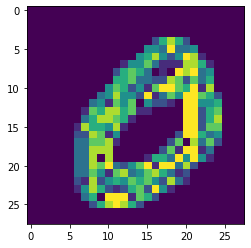

In [34]:
plt.imshow((pattern-4).reshape(28,28))

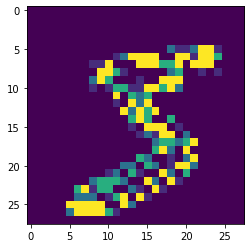

In [35]:
plt.imshow(torch.sum(out,dim=0))

In [29]:
out

tensor([[[-4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
          -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.],
         [-4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
          -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.],
         [-4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
          -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.],
         [-4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
          -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.],
         [-4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
          -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.],
         [-4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
          -4., -4., -4., -4., -1., -3., -3., -1.,  4.,  4., -3., -4., -4., -4.],
         [-4., -4., -4., -4., -4.,

In [30]:
pattern-4

tensor([-4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -2., -1.,  1.,  0.,  0.,  1.,  4.,  3.,  0., -3., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -3., -2.,  

In [31]:
torch.sum((pattern-4).reshape(28,28)-out)

tensor(341.)

In [32]:
torch.randint(-4,4,(784,)).type(torch.LongTensor)

tensor([ 1, -3,  3,  0, -2,  0, -2, -1,  0,  3, -4, -3, -1, -4,  3, -1,  2,  1,
        -3, -2,  2,  0,  3,  1, -1, -1,  2, -3, -1,  2,  3, -1,  3,  2, -4, -1,
         1,  1, -3, -3, -1,  3,  1, -2,  2, -2, -4,  3,  1, -4,  0,  1,  1, -4,
        -3,  1, -4, -2, -2, -3,  3, -1, -4,  2, -1,  0, -2,  1,  0,  1,  0, -3,
        -4,  0, -3,  2, -4,  3,  2, -1,  2,  2, -2, -3, -2,  1,  1,  3,  1, -1,
         0,  2,  1, -1,  2, -4,  3, -1,  1,  0, -1,  0,  0, -2,  2,  0, -4, -3,
         3,  3,  2, -2, -3, -3, -2,  2,  3,  2, -3, -2,  3,  2,  3,  1,  1, -4,
         3, -1,  2, -2, -3,  3,  2, -1, -3, -3, -1, -2, -4, -2,  3, -4, -2,  3,
        -1,  2,  3, -2, -1, -4, -1,  0,  1, -1,  0, -4, -4, -1, -3,  0, -4, -1,
         1,  1,  2,  0,  3, -4, -2,  2, -3,  3, -2,  2,  2,  2, -4,  0,  0,  1,
         3, -1, -4, -2,  1,  0,  0, -1, -1,  1, -3, -3, -4, -4,  2,  2,  2, -3,
         2,  3,  2, -2,  2, -3,  0,  3,  2,  3, -3,  3, -1,  0,  2,  1,  3, -1,
        -2, -3,  3, -4, -2,  0, -2,  1, 